In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Paths to dataset
train_data_dir = '/kaggle/working/train'
val_data_dir = '/kaggle/working/val'
test_data_dir = '/kaggle/working/test'

# Image properties
img_height, img_width = 224, 224
batch_size = 32
num_classes = 488  # Number of classes

# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    channel_shift_range=50.0,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

In [5]:
# Load datasets
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    val_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 31921 images belonging to 488 classes.
Found 4238 images belonging to 488 classes.
Found 3988 images belonging to 488 classes.


# `ResNet-50`

In [6]:
# Load ResNet50 with pre-trained ImageNet weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [7]:
# Freeze base layers
for layer in base_model.layers:
    layer.trainable = False  # Freeze pretrained layers

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)  # Regularization
predictions = Dense(num_classes, activation='softmax')(x)

In [8]:
model = Model(inputs=base_model.input, outputs=predictions)

In [9]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [11]:
# Fix steps to avoid running out of data
steps_per_epoch = max(1, len(train_generator))
validation_steps = max(1, len(val_generator))
test_steps = max(1, len(test_generator))

In [12]:
epochs = 20
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/20


998/998 ━━━━━━━━━━━━━━━━━━━━ 3593s 4s/step - accuracy: 0.0024 - loss: 6.2304 - val_accuracy: 0.0031 - val_loss: 6.1781 - learning_rate: 0.0010
Epoch 2/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20


998/998 ━━━━━━━━━━━━━━━━━━━━ 3593s 4s/step - accuracy: 0.0028 - loss: 6.1763 - val_accuracy: 0.0031 - val_loss: 6.1713 - learning_rate: 0.0010
Epoch 4/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 5/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 3577s 4s/step - accuracy: 0.0028 - loss: 6.1692 - val_accuracy: 0.0031 - val_loss: 6.1674 - learning_rate: 0.0010
Epoch 6/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 58us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 7/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 3579s 4s/step - accuracy: 0.0029 - loss: 6.1666 - val_accuracy: 0.0031 - val_loss: 6.1652 - learning_rate: 0.0010
Epoch 8/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 0s 62us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 9/20
998/998 ━━━━━━━━━━━━━━━━━━━━ 3601s 4s/step - accuracy: 0.0024 - loss: 6.1628 - val_accuracy: 0.0031 - val_loss: 6.1639 - learning_rate: 0.0010
Epoch 10/20
998/998 ━━━━━━━━━━━━━━━━━━━

In [13]:
# Save trained model
model.save('resnet50.h5')

# `Test Performance`

In [14]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]

In [15]:
# Evaluate model on test set
test_loss, final_test_acc = model.evaluate(test_generator, steps=test_steps)

125/125 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - accuracy: 0.0018 - loss: 6.1435


In [ ]:
# Print results
print("\nResNet50 Results:")
print(f"Final Train Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Test Accuracy: {final_test_acc:.4f}")


ResNet50 Results:
Final Train Accuracy: 0.0219
Final Validation Accuracy: 0.0316
Final Test Accuracy: 0.0341


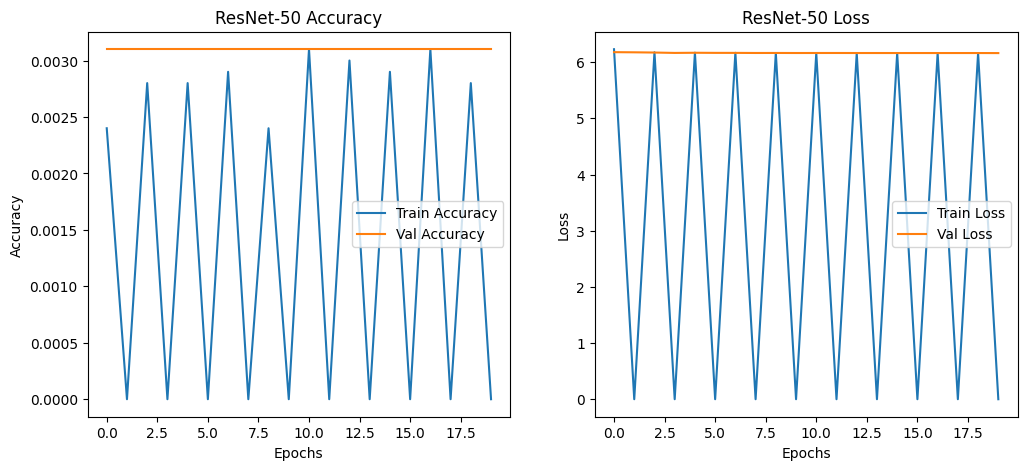

In [ ]:

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet-50 Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('ResNet-50 Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()